In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
import astropy.io.fits as fits
import glob
import os
from sklearn.neighbors import KDTree

In [2]:
plt.style.use('ggplot')

In [3]:
# our stellar models:

with np.load('model_atm_mags.npz') as nump_zip:
    model_atm_mags = nump_zip['model_atm_mags']

In [4]:
# our "data":

temp = np.load('truth_catalog.npz')
truth_catalog = temp['truth_catalog'].copy()
temp.close()

Checking that I did the zipping and unzipping right:

In [5]:
truth_catalog.dtype

dtype([('Teff', '<f8'), ('log_Z', '<f8'), ('gravity', '<f8'), ('F378', '<f8'), ('F395', '<f8'), ('F410', '<f8'), ('F430', '<f8'), ('F515', '<f8'), ('F660', '<f8'), ('F861', '<f8'), ('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('y', '<f8')])

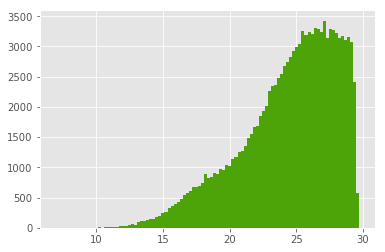

In [6]:
ack = plt.hist(truth_catalog['g'], bins=100, color='xkcd:Lawn Green')

Looks like it's supposed to. Moving on, copypasting the last bit of the previous notebook here, so the kdtrees and the LSST depth uncertainty-adding can be in one notebook.

## Broadband Tree:

In [7]:
color1 = model_atm_mags['u'] - model_atm_mags['g']
color2 = model_atm_mags['g'] - model_atm_mags['r']
color3 = model_atm_mags['r'] - model_atm_mags['i']
color4 = model_atm_mags['i'] - model_atm_mags['z']
color5 = model_atm_mags['z'] - model_atm_mags['y']

mag_model = np.array([color1, color2, color3, color4, color5]).T

In [8]:
broadleafed_tree = KDTree(mag_model)

In [9]:
bcolor1 = truth_catalog['u'] - truth_catalog['g']
bcolor2 = truth_catalog['g'] - truth_catalog['r']
bcolor3 = truth_catalog['r'] - truth_catalog['i']
bcolor4 = truth_catalog['i'] - truth_catalog['z']
bcolor5 = truth_catalog['z'] - truth_catalog['y']

sim_colors = np.array([bcolor1, bcolor2, bcolor3, bcolor4, bcolor5]).T
dist_bcolors, indx_match_bcolors = broadleafed_tree.query(sim_colors, k=1)

## Narrowband Tree:

In [10]:
model_ncolor0 = model_atm_mags['F861'] - model_atm_mags['z']
model_ncolor1 = model_atm_mags['r'] - model_atm_mags['F660']
model_ncolor2 = model_atm_mags['g'] - model_atm_mags['F515']
model_ncolor3 = model_atm_mags['F430'] - model_atm_mags['g']
model_ncolor4 = model_atm_mags['F410'] - model_atm_mags['g']
# could really go with either:
model_ncolor5a = model_atm_mags['F395'] - model_atm_mags['g']
# or:
model_ncolor5b = model_atm_mags['u'] - model_atm_mags['F395']
# or both, I suppose, if there's anything to be gained from doing so.
model_ncolor6 = model_atm_mags['u'] - model_atm_mags['F378']

ncolormodel = np.array(
    [model_ncolor0, model_ncolor1, model_ncolor2, model_ncolor3, model_ncolor4, model_ncolor5b, model_ncolor6]
).T

In [11]:
narrowleafed_tree = KDTree(ncolormodel)

In [12]:
nbcolor0 = truth_catalog['F861'] - truth_catalog['z']
nbcolor1 = truth_catalog['r'] - truth_catalog['F660']
nbcolor2 = truth_catalog['g'] - truth_catalog['F515']
nbcolor3 = truth_catalog['F430'] - truth_catalog['g']
nbcolor4 = truth_catalog['F410'] - truth_catalog['g']
# again, could really go with either:
nbcolor5a = truth_catalog['F395'] - truth_catalog['g']
# or:
nbcolor5b = truth_catalog['u'] - truth_catalog['F395']
# or both.
nbcolor6 = truth_catalog['u'] - truth_catalog['F378']

nbsim_colors = np.array([nbcolor0, nbcolor1, nbcolor2, nbcolor3, nbcolor4, nbcolor5b, nbcolor6]).T
dist_nbcolors, indx_match_nbcolors = narrowleafed_tree.query(nbsim_colors, k=1)

Checking that nothing's gone horribly wrong in the transportation from the last notebook:

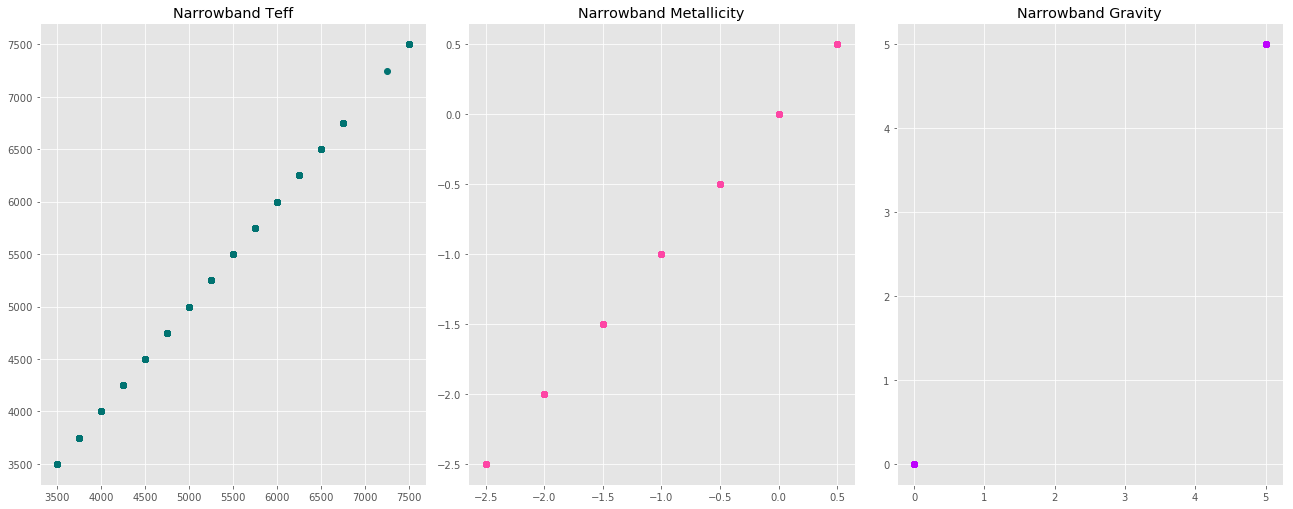

In [13]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches(18,7)

fig.tight_layout()

ax[0].set_title('Narrowband Teff')
ax[0].plot(truth_catalog['Teff'], model_atm_mags['Teff'][indx_match_nbcolors], 'ko', c='xkcd:Dark Aquamarine')

ax[1].set_title('Narrowband Metallicity')
ax[1].plot(truth_catalog['log_Z'], model_atm_mags['log_Z'][indx_match_nbcolors], 'ko', c='xkcd:Barbie Pink')

ax[2].set_title('Narrowband Gravity')
ax[2].plot(truth_catalog['gravity'], model_atm_mags['gravity'][indx_match_nbcolors], 'ko', c='xkcd:Bright Purple');

Well, that's a relief!

# Bringing the noise:

Yes me just pasting the numbers right there rather than making them into a table or something and then importing it in is really lazy. I'm okay with that.

In [14]:
# S/N Function. The magnitudes in truth_catalog will make up the former argument, and those numbers directly above,
# the latter. I hope, anyway, because that's what I'm doing.

def m52snr(m, m5):
    """
    Calculate the SNR for a star of magnitude m in an
    observation with 5-sigma limiting magnitude depth m5.
    Assumes gaussian distribution of photons and might not be
    strictly due in bluer filters. See table 2 and equation 5
    in astroph/0805.2366.

    Parameters
    ----------
    m : float or numpy.ndarray
        The magnitude of the star
    m5 : float or numpy.ndarray
        The m5 limiting magnitude of the observation

    Returns
    -------
    float or numpy.ndarray
        The SNR
    """
    snr = 5.*10.**(-0.4*(m-m5))
    return snr

In [15]:
def mag_error(m, snr):
    # https://www.eso.org/~ohainaut/ccd/sn.html
    dmag = 2.5*np.log10(1.+1./snr)
    return dmag

In [17]:
mag_names = ['u', 'g', 'r', 'i', 'z', 'y'] # maybe not needed

mag_depths_1yr = [
    25.593438315651625, 
    27.058813369707448, 
    27.136312824636949, 
    26.571196315062267, 
    25.653425773525129, 
    24.856152336639905,
]

In [16]:
# Trying to think of a way to not use a for loop here...

In [18]:
error_list = []

for element in truth_catalog:
    
    mag_list = []
    
    for i in list(range(6)):

        SNR = m52snr(element[-6+i], mag_depths_1yr[i])
        # Not bothering to put SNR in a list as it's really the error we're after.
        error = mag_error(element[-6+i], SNR)
        mag_list.append(error)

    error_list.extend([mag_list])

Testing on one star first:

In [19]:
test_obs = truth_catalog[500]
just_mags_test = []
for i in list(range(6)):
    just_mags_test.append(test_obs[-6+i])
just_mags_test

[25.305300525026979,
 23.622906124948798,
 23.0689122,
 22.874810091344358,
 22.797671384223221,
 22.751377361389231]

In [20]:
observed = []
for ii in list(range(len(just_mags_test))):
    observed.append((just_mags_test[ii] + np.random.randn(1) * error_list[500][ii]).tolist())

In [21]:
observed

[[25.131105165098475],
 [23.61030422099033],
 [23.067832129207634],
 [22.878071281346532],
 [22.804857700073416],
 [22.756262374887363]]

Well that's some progress, at any rate!

As goes the star, so goes the... lots of stars.

In [23]:
# As demonstrated above, going for working code moreso than efficient code here.

obs_ugrizy = []

for ii in list(range(len(truth_catalog))):
    
    observed = []
    
    for jj in list(range(6)):
        observed.append((truth_catalog[ii][-6+jj] + np.random.randn(1) * error_list[ii][jj]).tolist())
    
    obs_ugrizy.extend([observed])

In [24]:
obs_ugrizy[0:2]

[[[41.30116687846041],
  [28.197075722607114],
  [28.21492775036138],
  [27.24818331184335],
  [26.3911860746694],
  [24.957838350013947]],
 [[35.12075963448481],
  [27.65941741240137],
  [26.118492763118283],
  [25.15138397024575],
  [24.578664403911116],
  [24.380555968667252]]]

In [25]:
obs_ugrizy_mags = np.array(obs_ugrizy).reshape(122052, 6).T

In [26]:
obscolor1 = obs_ugrizy_mags[0] - obs_ugrizy_mags[1] # u-g
obscolor2 = obs_ugrizy_mags[1] - obs_ugrizy_mags[2] # g-r
obscolor3 = obs_ugrizy_mags[2] - obs_ugrizy_mags[3] # r-i
obscolor4 = obs_ugrizy_mags[3] - obs_ugrizy_mags[4] # i-z
obscolor5 = obs_ugrizy_mags[4] - obs_ugrizy_mags[5] # z-y

obs_colors = np.array([obscolor1, obscolor2, obscolor3, obscolor4, obscolor5]).T
dist_obscolors, indx_match_obscolors = broadleafed_tree.query(obs_colors, k=1)

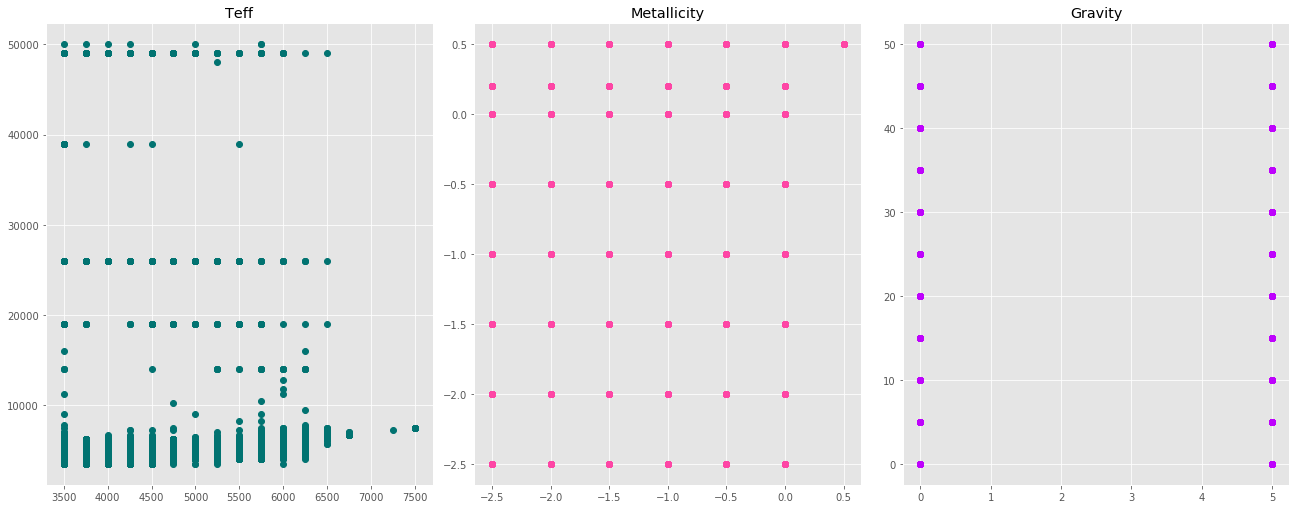

In [27]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches(18,7)

fig.tight_layout()

# uncomment the two lines below if you want to make Teff look slightly less bad...

#ax[0].set_xlim(3500, 7600)
#ax[0].set_ylim(3500, 7600)

ax[0].set_title('Teff')
ax[0].plot(truth_catalog['Teff'], model_atm_mags['Teff'][indx_match_obscolors], 'ko', c='xkcd:Dark Aquamarine')

ax[1].set_title('Metallicity')
ax[1].plot(truth_catalog['log_Z'], model_atm_mags['log_Z'][indx_match_obscolors], 'ko', c='xkcd:Barbie Pink')

ax[2].set_title('Gravity')
ax[2].plot(truth_catalog['gravity'], model_atm_mags['gravity'][indx_match_obscolors], 'ko', c='xkcd:Bright Purple');

We'll work on it...

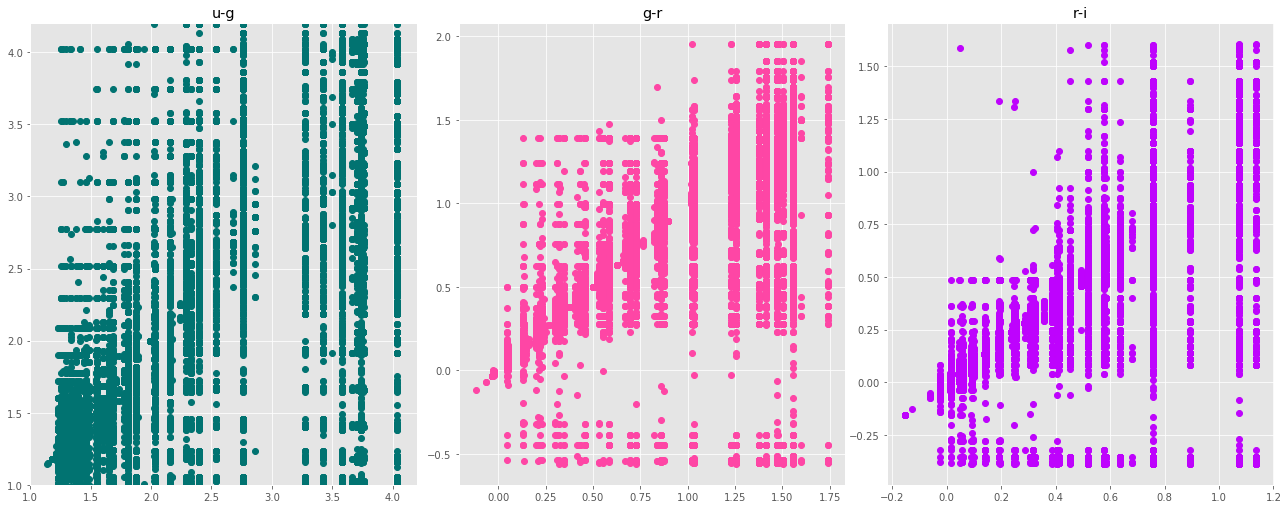

In [29]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches(18,7)

fig.tight_layout()

ax[0].set_xlim(1, 4.2)
ax[0].set_ylim(1, 4.2)
ax[0].set_title('u-g')
ax[0].plot(bcolor1, color1[indx_match_obscolors], 'ko', c='xkcd:Dark Aquamarine')

ax[1].set_title('g-r')
ax[1].plot(bcolor2, color2[indx_match_obscolors], 'ko', c='xkcd:Barbie Pink')

ax[2].set_title('r-i')
ax[2].plot(bcolor3, color3[indx_match_obscolors], 'ko', c='xkcd:Bright Purple');

That also could look better.